### Tutorial for using HYSPLIT in Python

For this tutorial, you must have previously installed [HYSPLIT](https://ready.arl.noaa.gov/HYSPLIT.php) on your machine. Much of the code here will write read/write files from/to disk. Disk locations are specified in config.py, along with the hysplit system call; edit these before use.

We'll walk through a couple operations here to demonstrate how to use this code.

1) Download some NCEP data,  
2) run a single forecast trajectory, and run a grid of analysis trajectories,  
3) plot a grid of trajectories (including reading trajectory files).

If anything is unclear, either consult the HYSPLIT [user guide](https://www.arl.noaa.gov/documents/reports/hysplit_user_guide.pdf) or email jkcm@uw.edu.

In [3]:
import hysplit_utils as utils
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
%load_ext autoreload
%autoreload 2

#### 1: Downloading Data  
HYSPLIT requires model data files to run locally. If you are using NCEP GFS (forecast) or GDAS (analysis) data, ARL (NOAA Air Resources Laboratory) provides these in a HYSPLIT-readable format [here](https://ready.arl.noaa.gov/HYSPLIT.php). If you wish to use e.g. ECMWF model data, they also provide conversion utilities. In this tutorial we will be using both GDAS and GFS forecast data for our trajectories.

If you are running this code at UW and looking at past analysis (or, for whatever reason, past forecast data), much of the data from 07/2015-04/2018 (time or writing) already exists on our local system, found at /home/disk/eos4/jkcm/Data/HYSPLIT/source/analysis (or /forecast). As these datafiles are 500MB per day, it saves download time and storage space to use these files so please feel free to do so.  
If you wish to use different data, or for different days, this package also contains code for downloading GDAS and GFS data directly from the ARL servers.

Data download functions in hysplit_utils module (each function checks to see whether the target file has already been downloaded, and uses ftp to download if not):  
**get_imagery:** download goestationary data from NASA SatCORPS, specified by satellite and date. This functionality works by the grace of the SatCORPS group, and breaks if they change naming or data availability.  
**get_hysplit_analysis:** downloads GDAS analysis for a provided date.  
**get_GDAS_data:** (convenience function) downloads GDAS analysis for a date and the entire week before it.  
**get_latest_hysplit_analysis:** (convenience function) downloads most recent GDAS analysis.  
**get_hysplit_appended_files:** download GFS 'appended forecast' (bridges gap between latest analysis and forecast).  
**get_hysplit_forecast_files:** download most recent forecast for a given date, default today.  

First we'll demonstrate downloading the most recent version of each data, for e.g. trajectories starting yesterday and going 3 days forward.

In [5]:
# download the most recent GFS forecast, analysis, and appended data (for near-future or recent-pass trajectories).
(latest_forecast, forecast_date) = utils.get_hysplit_forecast_files(dt.datetime(2018,11,24,23))
(latest_appended, appended_date)= utils.get_hysplit_appended_files(dt.datetime(2018,11,24,23))
(latest_analysis, analysis_date) = utils.get_latest_hysplit_analysis(dt.datetime(2018,11,24,23))

print("latest forecast: {} (covers 192 hours after this)".format(forecast_date))
print("latest appended: {} (covers 48 hours prior to this)".format(appended_date))
print("latest analysis: {} (covers 24 hours after this )".format(analysis_date))

Caught Exception in FTP transfer, looking locally...([WinError 3] The system cannot find the path specified: 'D:\\')


OSError: no local gfsf data found, FTP not available for 2018-11-24 23:00:00

Note the dates for different model data types sometimes represent represent the last valid timestep, sometimes the first. Details are in the HYSPLIT user guide for other resolutions/data types.

Next we'll fetch a week's worth of analysis from an old date, for the purposes of runnning backtrajectories.

In [3]:
#Get HYSPLIT analysis from one particular day + week before
date = dt.datetime(2018, 11, 25, 18, 0, 0)
(july2015_analysis_list, analysis_date) = utils.get_GDAS_data(date)

ARL: No analysis available for 20181125 yet...
ARL: No analysis available for 20181124 yet...
ARL: Attempting to find analysis file 20181123_gdas0p5 locally...
ARL: File already acquired, not downloading it again.
ARL: D:\MUA\model\gdas0p5_global\analysis\20181123_gdas0p5
ARL: Attempting to find analysis file 20181122_gdas0p5 locally...
ARL: File already acquired, not downloading it again.
ARL: D:\MUA\model\gdas0p5_global\analysis\20181122_gdas0p5
ARL: Attempting to find analysis file 20181121_gdas0p5 locally...
ARL: File already acquired, not downloading it again.
ARL: D:\MUA\model\gdas0p5_global\analysis\20181121_gdas0p5
ARL: Attempting to find analysis file 20181120_gdas0p5 locally...
ARL: File already acquired, not downloading it again.
ARL: D:\MUA\model\gdas0p5_global\analysis\20181120_gdas0p5
ARL: Attempting to find analysis file 20181119_gdas0p5 locally...
ARL: File already acquired, not downloading it again.
ARL: D:\MUA\model\gdas0p5_global\analysis\20181119_gdas0p5
ARL: Attemp

#### 2) Running trajectories

Next we'll run some trajectories, using the HYSPLIT data we just downloaded. To see the full range of options for running HYSPLIT, either look at the docstring for hysplit_utils.write_control_file(), and read the HYSPLIT user guide. 
HYSPLIT needs to know the following parameters: trajectory start time, point(s) from which to run trajectories, list of source files on disk, hours to run, vertical motion type (level, fixed pressure, etc), initialization height, and save directory. 

A few things to note:  
1) for the list of source files, they are traversed in listed order, so always place analysis first in the list, to give it priority over appended data.  
2) always provide a list of (lat, lon) coordinates. 
3) negative hours means backtrajectories  
4) height defaults to above ground level  
5) write_control_file creates the HYSPLIT control file, but does not call HYSPLIT (next step). The output location for HYSPLIT is determined by a line in the control file, and so that location is returned. 

In [5]:
# run a single trajectory forward using forecast data. Let's do 3 days, 3D, 
# starting 24 hours before our latest forecast (i.e. sometime yesterday)
forecast_tdump = utils.write_control_file(start_time = forecast_date-dt.timedelta(days=1),
                                          coords = [(47, -122)],
                                          hyfile_list = [latest_analysis, latest_appended, latest_forecast],
                                          hours = 72,
                                          vertical_type = 0,
                                          init_height = 4000,
                                          tdump_prefix='demo_')
utils.run_HYSPLIT(); # this should take a few seconds. 

finished running HYSPLIT.


In [6]:
# lets run a grid of trajectories, and use one the grid-making utility functions.
grid_coords = utils.gridder(SW=(50, 1), NW=(60, 1), NE=(60, 10), SE=(50, 10), 
                      numlats=6, numlons=6)
historical_tdump = utils.write_control_file(start_time = analysis_date,
                                          coords = grid_coords,
                                          hyfile_list = july2015_analysis_list,
                                          hours = -4*24,
                                          vertical_type = 1,  # isobaric
                                          init_height = 4000,
                                          tdump_prefix='demo_')
utils.run_HYSPLIT(); # this should take about 20 seconds. 

finished running HYSPLIT.


#### 3) Reading and plotting trajectory output   
Finally we'll use the two examples so far to illustrate how to read in those tdump files and plot them. You can do this by hand (if you navigate to the location on disk in e.g. forecast_tdump, you'll find a plaintext file containing trajectory data). Trajectories are read in as a pandas DataFrame. For multi-trajectory files, 'tnum' indexes the trajectory number.

In [7]:
# demo for how to read trajectory data
forecast_traj = utils.read_tdump(forecast_tdump)
trajectory_grouped = forecast_traj.groupby('tnum')
print("trajectory numbers: {}".format(trajectory_grouped.groups.keys()))
trajectory_1 = trajectory_grouped.get_group(1)
print("trajectory columns: {}".format(trajectory_1.columns.values))
plt.plot(trajectory_1.index.values, trajectory_1['height'])
plt.xlabel("date")
plt.ylabel("height (m)")
plt.grid(True)

trajectory numbers: dict_keys([1])
trajectory columns: ['tnum' 'gnum' 'fhour' 'age' 'lat' 'lon' 'height' 'pres']


Included in this package a few plotting functions as well, which might be helpful. We'll demonstrate using these to visualize trajectories.

C:\Users\zhenping\Software\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


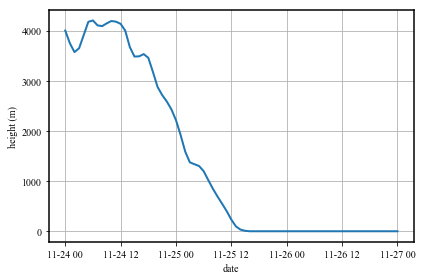

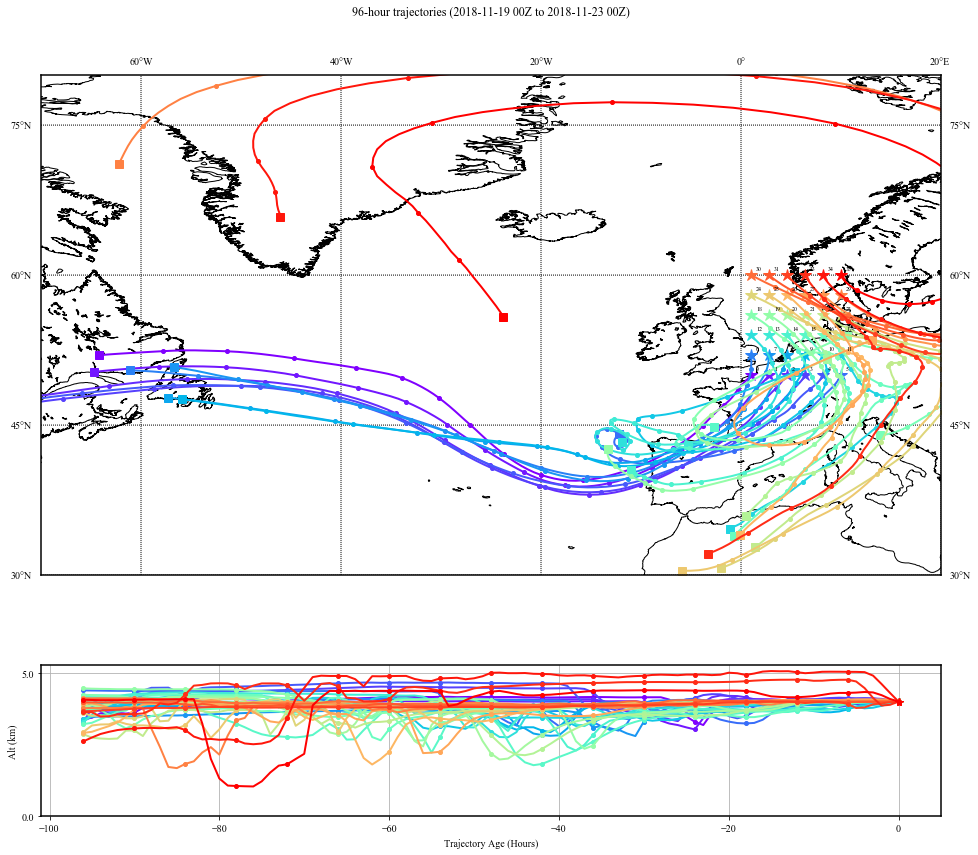

In [8]:
latlon_range = {'lat': (30, 80), 'lon': (-70, 20)}
fig = utils.plot_tdump_with_heights(historical_tdump, latlon_range=latlon_range)
fig.set_size_inches(12.5, 10.5)
plt.show()

C:\Users\zhenping\Software\lib\site-packages\mpl_toolkits\basemap\__init__.py:4828: RuntimeWarning: invalid value encountered in less
  mask = np.logical_or(lonsin<lon_0-180,lonsin>lon_0+180)
C:\Users\zhenping\Software\lib\site-packages\mpl_toolkits\basemap\__init__.py:4828: RuntimeWarning: invalid value encountered in greater
  mask = np.logical_or(lonsin<lon_0-180,lonsin>lon_0+180)
C:\Users\zhenping\Software\lib\site-packages\mpl_toolkits\basemap\__init__.py:3394: RuntimeWarning: invalid value encountered in greater
  x = ma.masked_values(np.where(x > 1.e20,1.e20,x), 1.e20)
C:\Users\zhenping\Software\lib\site-packages\mpl_toolkits\basemap\__init__.py:3395: RuntimeWarning: invalid value encountered in greater
  y = ma.masked_values(np.where(y > 1.e20,1.e20,y), 1.e20)
C:\Users\zhenping\Software\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure include

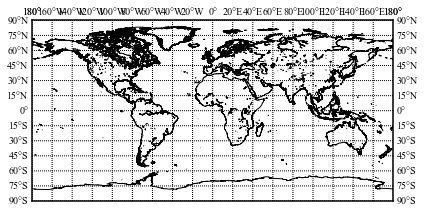

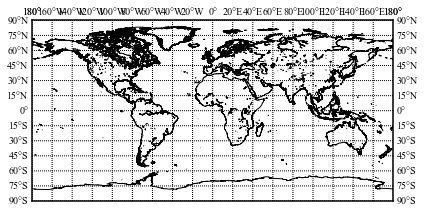

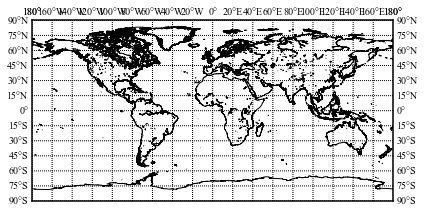

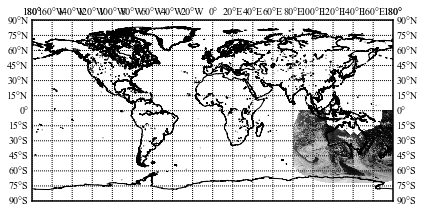

In [16]:
m = utils.bmap()
utils.add_satellite_to_map(m, 'D:\\MUA\\satellite\\geostationary_image\\Meteosat-10\\HM8V03.0.SH.2018324.0000.PX.06K.NC')
plt.show()